# Final Project
## Création d'une application pour detecter la pneumonie à partir d'images de radio thoraciques à l'aide du deep learning( Model CNN).

Construire un modèle de classification d’image simple en utilisant un réseau neuronal convolutif (CNN) pour détecter la présence de pneumonie à partir d’images radiographiques thoraciques.


- La pneumonie est une infection courante qui enflamme les sacs aériens dans les poumons provoquant des symptômes tels que des difficultés respiratoires et de la fièvre. Même si la pneumonie n’est pas difficile à traiter, un diagnostic rapide est crucial. Sans traitement approprié, la pneumonie peut devenir mortelle, en particulier chez les enfants et les personnes âgées. La radiographie pulmonaire est une méthode abordable pour le diagnostic de la pneumonie. Le développement d’un modèle capable de classer de manière fiable la pneumonie à partir d’images radiographiques peut alléger la charge de médecins dans les zones où la demande est élevée.


# Data Structure
Le dossier du dataset  doit être structuré comme ci-dessous

*DATA*

> *Train*
- NORMAL
- PNEUMONIA


> *Test*
- NORMAL
- PNEUMONIA


> Validation 
- NORMAL
- PNEUMONIA 



# importing libraries 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
import cv2
import random
import os
import pickle
import os
import gc
from timeit import default_timer as timer
import glob
from tqdm.notebook import tqdm
import tensorflow as tf
import albumentations as A
from keras import regularizers
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.callbacks import EarlyStopping

# Loading Data


# Loading Data

- Pour obtenir toutes les catégories sous le chemin du dossier dans une liste, nous utilisons une méthode glob


In [ ]:
train_data = glob.glob("/content/drive/MyDrive/JEDHA-PNEUMONIA/Pneumonia-Project/chest_xray/data_checked_selim/train//**/*.jpeg")
test_data = glob.glob("/content/drive/MyDrive/JEDHA-PNEUMONIA/Pneumonia-Project/chest_xray/data_checked_selim/test//**/*.jpeg")
val_data = glob.glob("/content/drive/MyDrive/JEDHA-PNEUMONIA/Pneumonia-Project/chest_xray/data_checked_selim/val//**/*.jpeg")
print(f"Training Set has: {len(train_data)} images")
print(f"Testing Set has: {len(test_data)} images")
print(f"Validation Set has: {len(val_data)} images")

Training Set has: 5216 images
Testing Set has: 624 images
Validation Set has: 16 images


#  Data Distribution

Total Pneumonia Images: 4273
Total Normal Images: 1583


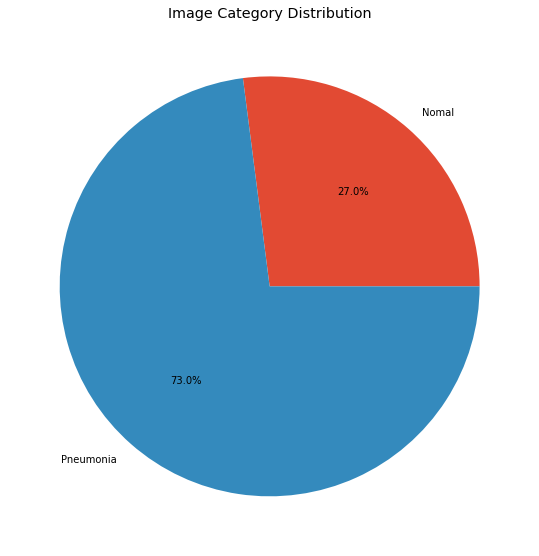

In [ ]:
DIR = "/content/drive/MyDrive/JEDHA-PNEUMONIA/Pneumonia-Project/chest_xray/data_checked_selim"
sets = ["train", "test", "val"]
all_pneumonia = []
all_normal = []

for cat in sets:
    path = os.path.join(DIR, cat)
    norm = glob.glob(os.path.join(path, "NORMAL/*.jpeg"))
    pneu = glob.glob(os.path.join(path, "PNEUMONIA/*.jpeg"))
    all_normal.extend(norm)
    all_pneumonia.extend(pneu)

print(f"Total Pneumonia Images: {len(all_pneumonia)}")
print(f"Total Normal Images: {len(all_normal)}")




labels = ['Nomal', 'Pneumonia']
targets = [len(all_normal), len(all_pneumonia)]

plt.style.use("ggplot")
plt.figure(figsize=(16, 9))
plt.pie(x=targets, labels=labels, autopct="%1.1f%%")
plt.title("Image Category Distribution")
plt.show()

- Un peu de déséquilibre de classe. Cela favorisera la pneumonie, qui est un cas que nous voulons, nous devrions donc réévaluer nos mesures d'évaluation.

# preprocessing

Nous utilisons Keras ImageDataGenerator pour redimensionner les données. Toutes les valeurs de pixel sont normalisées pour être comprises entre 0 et 1

In [ ]:
#We use Keras ImageDataGenerator to resize the data. All pixel values are normalized to be between 0 - 1.
train_g = image.ImageDataGenerator(rescale = 1/255).flow_from_directory("/content/drive/MyDrive/JEDHA-PNEUMONIA/Pneumonia-Project/chest_xray/data_checked_selim/train",
                                                                  target_size = (256,256), 
                                                                  color_mode='grayscale',
                                                                  class_mode='binary')
val_g = image.ImageDataGenerator(rescale = 1/255).flow_from_directory("/content/drive/MyDrive/JEDHA-PNEUMONIA/Pneumonia-Project/chest_xray/data_checked_selim/test",
                                                                target_size = (256,256), 
                                                                color_mode='grayscale',
                                                                class_mode='binary')


Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


keras.image.ImageDataGenerator() prend des images et crée des données augmentées en fonction des paramètres. Ici, nous lui demandons simplement de redimensionner toutes les valeurs de pixels pour qu’elles soient de 0 à 1 sans spécifier d’autres paramètres d’augmentation. Combiné avec , le générateur appelle des images du répertoire dans le format attribué, puis crée des données redimensionnées.

# Plotting results

In [ ]:
def plot_performance(hist):
    hist_ = hist.history
    epochs = hist.epoch
    
    plt.plot(epochs, hist_['accuracy'], label='Training Accuracy')
    plt.plot(epochs, hist_['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    
    plt.figure()
    plt.plot(epochs, hist_['loss'], label='Training loss')
    plt.plot(epochs, hist_['val_loss'], label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    recall = np.array(hist_['recall'])
    precision = np.array(hist_['precision'])
    val_recall = np.array(hist_['val_recall'])
    val_precision = np.array(hist_['val_precision'])
    plt.figure()
    plt.plot(epochs, 
             2*((recall * precision)/(recall + precision)), 
             label='Training f1')
    plt.plot(epochs, 
             2*((val_recall * val_precision)/(val_recall + val_precision)), 
             label='Validation f1')
    plt.title('Training and validation F1-Score')
    plt.legend()
    
    plt.show()

# Basic model (1)
**1.Model Architecture**

- **keras.models.Sequential()** lance un modèle séquentiel. Ce modèle traitera séquentiellement les couches ajoutées.

- Les couches **Conv2D** sont les couches convolutives, qui prennent l'entrée et les font passer par le nombre de filtres attribué. La taille du karnel fait référence à la dimension des filtres. Ainsi, dans cet exemple, chaque groupe consécutif de 3 * 3 pixels dans notre image 256 * 256 * 1 (1 faisant référence au nombre de channels, les images RGB ont 3 channels, tandis que les images en niveaux de gris ont 1 chanel) passera par 32 filtres générant 32 comportent des cartes d'une taille de 256 * 256 * 1.
- **padding = 'same'** est une technique consistant à ajouter des pixels remplis de zéros tout autour de l'entrée d'origine sur toutes les dimensions de convolution.
- **Karnel size** représente la hauteur et la largeur du filtre

- **activation = 'relu'** signifie que nous attribuons l’unité linéaire rectifiée comme fonction d’activation. En termes simples, nous disons à la couche de convertir toutes nos valeurs négatives en 0.
- Les couches **MaxPooling** prennent l'image d'entrée et résument son contenu selon une fonction d'agrégation (max)
 
- **Fonction sigmoïde** est appliquée en tant que fonction d’activation sur la couche finale parce que nous voulons maintenant que le modèle produise une probabilité de savoir si la sortie est une pneumonie ou non.

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, 3, activation = 'relu', padding = 'same', input_shape=(256, 256, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, 3, activation = 'relu', padding = 'same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, 3, activation = 'relu', padding = 'same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, 3, activation = 'relu', padding = 'same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 128)      0

- Nous avons défini l’architecture de notre modèle. L’étape suivante consiste à décider de l’objectif de ce modèle et de la façon dont nous voulons qu’il y parvienne. Nous disons au modèle de minimiser la perte  binary cross-entropy (la perte logarithmique) en utilisant la descente de gradient. Ici, nous utilisons l’algorithme RMSprop pour optimiser ce processus en diminuant de manière adaptative le taux d’apprentissage.

- Ce modèle cessera de fonctionner si notre perte de validation n’est pas réduite pendant 5 époques consécutives

In [ ]:
# compiling models
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['accuracy', 'Recall', 'Precision'])

# early stopping
# setting up an early stopping callbacks to avoid overfitting
# stop if a validation loss is not reduced for 5 epochs 
cp = EarlyStopping(patience = 5, restore_best_weights=True)



/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
history = model.fit(train_g, # fit train generator
                    epochs=20, # it will be stopped before  epochs (early stopping)
                    validation_data = val_g, # use the assigned generator as a validation set
                    callbacks = [cp], # use cp as callback
                    verbose = 2 # report each epoch without progress bar
                   )


Epoch 1/20
163/163 - 1128s - loss: 0.2492 - accuracy: 0.8907 - recall: 0.9437 - precision: 0.9122 - val_loss: 0.4250 - val_accuracy: 0.8558 - val_recall: 0.9615 - val_precision: 0.8333 - 1128s/epoch - 7s/step
Epoch 2/20
163/163 - 77s - loss: 0.1152 - accuracy: 0.9584 - recall: 0.9729 - precision: 0.9711 - val_loss: 1.1600 - val_accuracy: 0.7163 - val_recall: 0.9974 - val_precision: 0.6885 - 77s/epoch - 473ms/step
Epoch 3/20
163/163 - 77s - loss: 0.0911 - accuracy: 0.9686 - recall: 0.9778 - precision: 0.9798 - val_loss: 0.8903 - val_accuracy: 0.7804 - val_recall: 0.9846 - val_precision: 0.7456 - 77s/epoch - 471ms/step
Epoch 4/20
163/163 - 76s - loss: 0.0768 - accuracy: 0.9732 - recall: 0.9817 - precision: 0.9822 - val_loss: 0.8671 - val_accuracy: 0.7644 - val_recall: 0.9949 - val_precision: 0.7280 - 76s/epoch - 469ms/step
Epoch 5/20
163/163 - 76s - loss: 0.0675 - accuracy: 0.9780 - recall: 0.9845 - precision: 0.9858 - val_loss: 0.6742 - val_accuracy: 0.8109 - val_recall: 0.9795 - val_pr

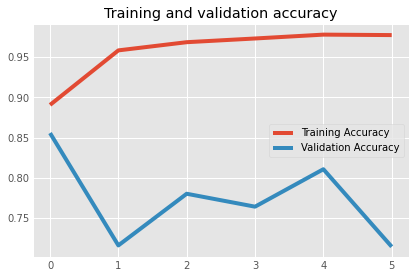

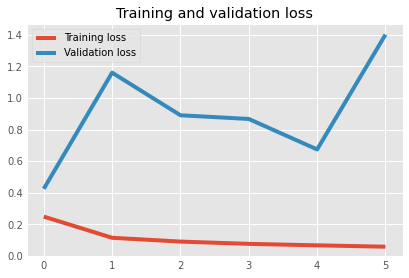

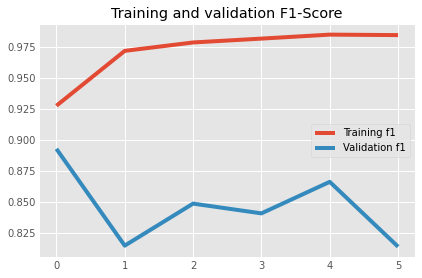

In [ ]:
plot_performance(history)

In [ ]:
model.evaluate(val_g, verbose = 2)

20/20 - 7s - loss: 0.4250 - accuracy: 0.8558 - recall: 0.9615 - precision: 0.8333 - 7s/epoch - 362ms/step


[0.42498597502708435,
 0.8557692170143127,
 0.9615384340286255,
 0.8333333134651184]

- Notre premier modèle a montré une accuracy de 83%. Sur la base du graphique ci-dessus, nous pouvons voir que la perte d’entraînement peut être améliorée, de sorte que nous pouvons probablement augmenter la complexité du modèle. Nous pouvons essayer d’améliorer la généralisabilité en imitant l’ajout de plus de données en utilisant la data augmentation.

In [ ]:
model.save("/content/drive/MyDrive/JEDHA-PNEUMONIA/Dossier -samedi-manipulation-best-model/premir_mod_simple.h5")

# model (2) with data augmentation 
 
- Maintenant, nous allons essayer de mettre en œuvre la data augmentation  et d’ajouter plus de complexité à notre modèle.

**Data augmentation**
- Cette fois, nous avons ajouté quelques paramètres à notre générateur de données d’image de train. Par conséquent, notre générateur va maintenant créer de nouvelles images pour chaque lot en appliquant une rotation, une luminosité, un cisaillement et un zoom différents dans la plage attribuée à l’ensemble d’images d’origine.

**Complexité du modèle**

- Nous avons également augmenté la complexité du modèle en ajoutant plus de couches convolutives et de mise en commun. En revanche on va augmenter le nombre de filtres de convolution au fur et à mesure .


In [ ]:
data_aug_train = image.ImageDataGenerator(rescale = 1/255,
                                          rotation_range = 15,
                                          brightness_range = [0.9, 1.1],
                                          shear_range=5,
                                          zoom_range = 0.2)

train_g2 = data_aug_train.flow_from_directory("/content/drive/MyDrive/JEDHA-PNEUMONIA/Pneumonia-Project/chest_xray/data_checked_selim/train",
                                              target_size = (256,256), 
                                              color_mode='grayscale',
                                              class_mode='binary')

Found 5216 images belonging to 2 classes.


In [ ]:
#Adding complexity to our model 
model = models.Sequential()
model.add(layers.Conv2D(32, 3, activation = 'relu', padding = 'same', input_shape=(256, 256, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, 3, activation = 'relu', padding = 'same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, 3, activation = 'relu', padding = 'same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, 3, activation = 'relu', padding = 'same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(512, 3, activation = 'relu', padding = 'same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(2048, activation = 'relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 256, 256, 32)      320       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 128, 128, 32)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 32, 32, 128)     

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(amsgrad = True),
              metrics=['accuracy', 'Recall', 'Precision'])

Epoch 1/20
163/163 - 951s - loss: 0.3552 - accuracy: 0.8512 - recall: 0.9288 - precision: 0.8780 - val_loss: 0.3246 - val_accuracy: 0.8750 - val_recall: 0.9462 - val_precision: 0.8662 - 951s/epoch - 6s/step
Epoch 2/20
163/163 - 107s - loss: 0.2197 - accuracy: 0.9116 - recall: 0.9404 - precision: 0.9406 - val_loss: 0.4834 - val_accuracy: 0.7997 - val_recall: 1.0000 - val_precision: 0.7573 - 107s/epoch - 656ms/step
Epoch 3/20
163/163 - 108s - loss: 0.1930 - accuracy: 0.9214 - recall: 0.9474 - precision: 0.9469 - val_loss: 0.2750 - val_accuracy: 0.9022 - val_recall: 0.9385 - val_precision: 0.9082 - 108s/epoch - 664ms/step
Epoch 4/20
163/163 - 108s - loss: 0.1695 - accuracy: 0.9321 - recall: 0.9525 - precision: 0.9560 - val_loss: 0.3544 - val_accuracy: 0.9038 - val_recall: 0.9795 - val_precision: 0.8802 - 108s/epoch - 660ms/step
Epoch 5/20
163/163 - 108s - loss: 0.1683 - accuracy: 0.9335 - recall: 0.9541 - precision: 0.9563 - val_loss: 0.4355 - val_accuracy: 0.8910 - val_recall: 0.9897 - v

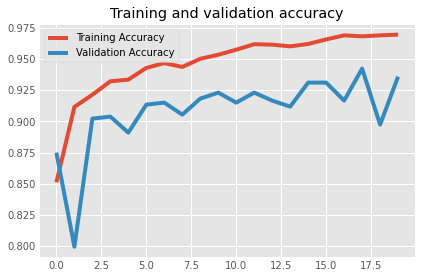

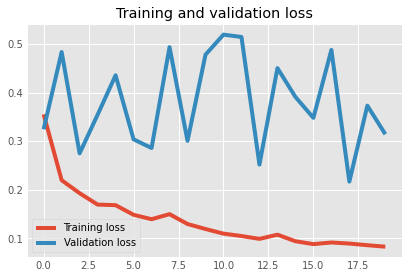

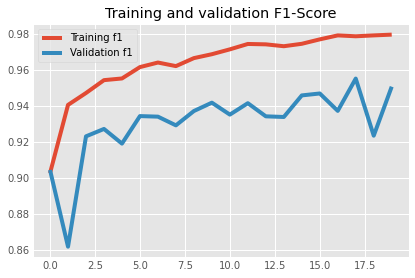

In [ ]:
history = model.fit(train_g2, # fit train generator
                    epochs=20, # it will be stopped before  epochs (early stopping)
                    validation_data = val_g, # use the assigned generator as a validation set
                    #callbacks = [cp], # use cp as callback
                    verbose = 2 # report each epoch without progress bar
                   )
plot_performance(history)
model.save("/content/drive/MyDrive/JEDHA-PNEUMONIA/Dossier -samedi-manipulation-best-model/model_with_data-aug2.h5")


In [ ]:
model.evaluate(val_g, verbose = 2)

20/20 - 8s - loss: 0.3142 - accuracy: 0.9359 - recall: 0.9872 - precision: 0.9167 - 8s/epoch - 380ms/step


[0.3142438232898712,
 0.9358974099159241,
 0.9871794581413269,
 0.9166666865348816]

- Notre deuxième modèle a montré une accuracy de 93% 
- Il semble que nos ajustements aient en effet amélioré notre modèle ! Testons-le sur notre ensemble de tests pour nous assurer qu’ils généralisent bien aux données invisibles.

In [ ]:
test_g0 = image.ImageDataGenerator(rescale = 1/255)

def get_pred(path):
    filelist = os.listdir(path)
    result = {}

    for fn in filelist:
        image_ = image.load_img(f'{path}/{fn}', 
                                target_size = (256,256), 
                                color_mode='grayscale')
        input_ = np.array([image.img_to_array(image_)])
        input_f = test_g0.flow(input_)
        result[fn] = int(np.where(model.predict(input_f)[0] > 0.5, 1, 0))
    return result

In [ ]:
Neg_class_preds = get_pred('/content/drive/MyDrive/JEDHA-PNEUMONIA/Pneumonia-Project/chest_xray/data_checked_selim/test/NORMAL')
Pos_class_preds = get_pred('/content/drive/MyDrive/JEDHA-PNEUMONIA/Pneumonia-Project/chest_xray/data_checked_selim/test/PNEUMONIA')

In [ ]:
FP_list = [k for k, v in Neg_class_preds.items() if v != 0]
FN_list = [k for k, v in Pos_class_preds.items() if v != 1]

# Confusion Matrix

In [ ]:
# getting numbers for confusion matrix
FP = len(FP_list)
FN = len(FN_list)
TP = len(Pos_class_preds) - FP
TN = len(Neg_class_preds) - FN

In [ ]:
print("different numbers of confusion matrix ", FP, FN, TP, TN)

different numbers of confusion matrix  35 5 355 229


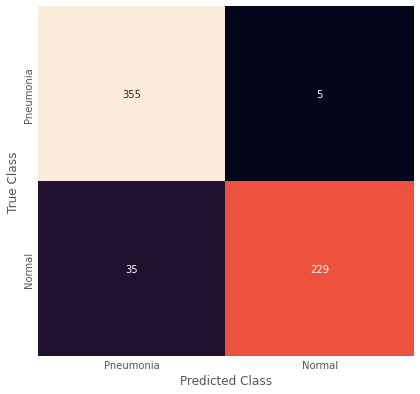

In [ ]:
import seaborn as sns
cm = [[TP, FN], [FP, TN]]
plt.figure(figsize = (6, 6))
sns.heatmap(cm, annot=True, fmt="d", cbar = False, xticklabels=['Pneumonia', 'Normal'], yticklabels = ['Pneumonia', 'Normal'])
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

- Notre modèle a prédit la classe des images X_ray dans l’ensemble de validation  avec une précision de 94%. Il a identifié avec succès 94% des cas de pneumonie.

# model (3) fitting overfitting
optimize the model by reducing overfitting with L2 Regularization and the Dropout technique

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, 3, activation = 'relu', padding = 'same', input_shape=(256, 256, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, 3, activation = 'relu', padding = 'same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, 3, activation = 'relu', padding = 'same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, 3, activation = 'relu', padding = 'same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(512, 3, activation = 'relu', padding = 'same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(2048, activation = 'relu', kernel_regularizer=regularizers.l2(0.0001)))
model.add(Dropout(0.3))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 256, 256, 32)      320       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 128, 128, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 64, 64, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 32, 32, 128)     

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(amsgrad = True),
              metrics=['accuracy', 'Recall', 'Precision'])

Epoch 1/20
163/163 - 116s - loss: 0.4700 - accuracy: 0.8472 - recall: 0.9396 - precision: 0.8661 - val_loss: 0.4198 - val_accuracy: 0.8478 - val_recall: 0.9590 - val_precision: 0.8256 - 116s/epoch - 710ms/step
Epoch 2/20
163/163 - 115s - loss: 0.2917 - accuracy: 0.9005 - recall: 0.9365 - precision: 0.9300 - val_loss: 0.4832 - val_accuracy: 0.8349 - val_recall: 0.9744 - val_precision: 0.8034 - 115s/epoch - 703ms/step
Epoch 3/20
163/163 - 115s - loss: 0.2220 - accuracy: 0.9247 - recall: 0.9507 - precision: 0.9480 - val_loss: 0.4992 - val_accuracy: 0.8494 - val_recall: 0.9897 - val_precision: 0.8109 - 115s/epoch - 708ms/step
Epoch 4/20
163/163 - 113s - loss: 0.2259 - accuracy: 0.9250 - recall: 0.9505 - precision: 0.9487 - val_loss: 0.4141 - val_accuracy: 0.8926 - val_recall: 0.9410 - val_precision: 0.8929 - 113s/epoch - 692ms/step
Epoch 5/20
163/163 - 111s - loss: 0.2117 - accuracy: 0.9298 - recall: 0.9538 - precision: 0.9518 - val_loss: 0.3864 - val_accuracy: 0.8846 - val_recall: 0.9795 

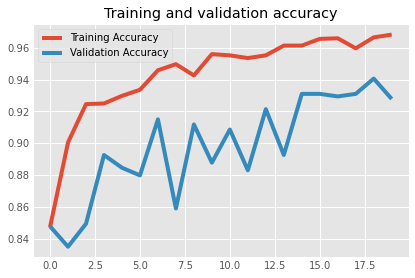

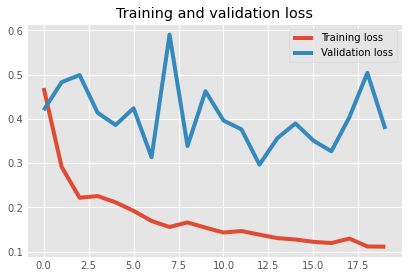

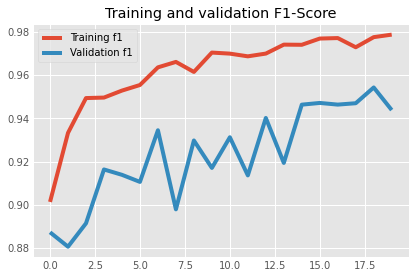

In [ ]:
history = model.fit(train_g2, # fit train generator
                    epochs=20, # it will be stopped before  epochs (early stopping)
                    validation_data = val_g, # use the assigned generator as a validation set
                    #callbacks = [cp], # use cp as callback
                    verbose = 2 # report each epoch without progress bar
                   )
plot_performance(history)
model.save("/content/drive/MyDrive/JEDHA-PNEUMONIA/Dossier -samedi-manipulation-best-model/model_with_data-aug4.h5")

In [ ]:
model.evaluate(val_g, verbose = 2)

20/20 - 7s - loss: 0.3773 - accuracy: 0.9279 - recall: 0.9692 - precision: 0.9197 - 7s/epoch - 364ms/step


[0.37725579738616943,
 0.9278846383094788,
 0.9692307710647583,
 0.9197080135345459]

In [ ]:
test_g0 = image.ImageDataGenerator(rescale = 1/255)

def get_pred(path):
    filelist = os.listdir(path)
    result = {}

    for fn in filelist:
        image_ = image.load_img(f'{path}/{fn}', 
                                target_size = (256,256), 
                                color_mode='grayscale')
        input_ = np.array([image.img_to_array(image_)])
        input_f = test_g0.flow(input_)
        result[fn] = int(np.where(model.predict(input_f)[0] > 0.5, 1, 0))
    return result

In [ ]:
Neg_class_preds = get_pred('/content/drive/MyDrive/JEDHA-PNEUMONIA/Pneumonia-Project/chest_xray/data_checked_selim/test/NORMAL')
Pos_class_preds = get_pred('/content/drive/MyDrive/JEDHA-PNEUMONIA/Pneumonia-Project/chest_xray/data_checked_selim/test/PNEUMONIA')

In [ ]:
FP_list = [k for k, v in Neg_class_preds.items() if v != 0]
FN_list = [k for k, v in Pos_class_preds.items() if v != 1]

In [ ]:
# getting numbers for confusion matrix
FP = len(FP_list)
FN = len(FN_list)
TP = len(Pos_class_preds) - FP
TN = len(Neg_class_preds) - FN

In [ ]:
print("different numbers of confusion matrix ", FP, FN, TP, TN)

different numbers of confusion matrix  33 12 357 222


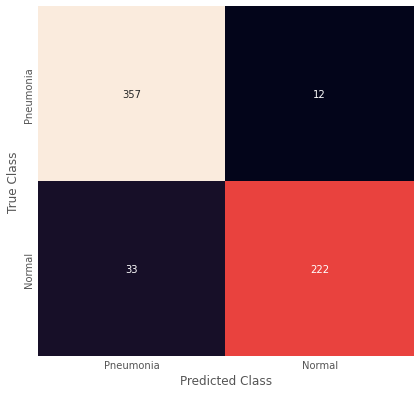

In [ ]:
import seaborn as sns
cm = [[TP, FN], [FP, TN]]
plt.figure(figsize = (6, 6))
sns.heatmap(cm, annot=True, fmt="d", cbar = False, xticklabels=['Pneumonia', 'Normal'], yticklabels = ['Pneumonia', 'Normal'])
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

# Conclusion 

- Notre modèle a montré qu’il est capable de détecter correctement près de 94% des cas de pneumonie compte tenu de notre ensemble de données à l’aide d’un réseau neuronal convolutif

- Nous pouvons améliorer le model à partir des exemples suivants :

> 
> - Enrichir les données (+images radio)
- Construire un dataset plus équlibré
- Utiliser plus de données dans le validation set
- Utiliser et comparer avec d’autres variantes du modèle CNN : RCNN – Faster RCNN
- Utiliser des ressources/machines plus robustes
_ Exploiter le transfert de connaissances
- Réduire le problème de sur-apprentissage (overfitting)
